# ÉCOLE IVADO/Mila EN APPRENTISSAGE PROFOND
# SESSION D'AUTOMNE 2018 
# Tutoriel : Réseaux de neurones récurrents (RNR/RNN)



## Auteurs

Francis Grégoire <francis.gregoire@rd.mila.quebec>

Jeremy Pinto <jeremy.pinto@rd.mila.quebec>

Jean-Philippe Reid <Jean-Philippe.Reid@ElementAI.com>

## Préface

Ce tutoriel contient deux exemples ayant comme objectif d'introduire des concepts fondamentaux sur les réseaux de neurones récurrents (RNR/RNN et LMCT/LSTM).

La première tâche consiste d'un exemple plutôt élémentaire servant à mettre en évidence l'avantage d'utiliser un modèle LSTM contre un simple RNN.

Dans la deuxième tâche, nous allons mettre en valeur un modèle LSTM de manière plus concrète en développant un modèle de langue neuronal pour générer du nouveau texte. Dans cet exemple, vous allez apprendre comment faire le prétraitement des données textuelles dans le but de réussir à entraîner un modèle de langue neuronal de manière efficace.

---
# Initialisation et importation des librairies

Pour assurer le bon fonctionnement de ce notebook sur Colab, il est nécessaire d'installer quelques librairies à l'aide de `pip`. Tout d'abord, assurez-vous d'être connectés au notebook (✓ CONNECTED en haut à droite). Exécutez ensuite la cellule suivante en la sélectionnant et en cliquant `shift`+`Enter`. L'installation peut prendre quelques minutes.

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Graine pour reproduire les résultats.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("version PyTorch: ", torch.__version__)
print("GPU disponible: {}".format(use_gpu))

version PyTorch:  1.6.0
GPU disponible: False


---
# Tâche 1: Sommes de nombres


## Objectif

L'objectif de cet exemple est de construire un modèle capable de faire la somme d'une série de nombres. Il s'agit d'une tâche très simple (une calculatrice de poche peut facilement l'exécuter!) et servira à souligner certaines limitations des RNN. L'ensemble de données est facile à générer et nous permet de rapidement tester la capacité à modéliser une longue séquence entre un RNN traditionnel et un LSTM.



## Ensemble de données

L'ensemble de données est constitué d'un ensemble de séquences de nombres de longueur $seq\_len$ où une cible est associée à chacune. Dans notre cas, la cible d'une séquence est associée à la somme des nombres de la séquence. Ainsi, pour un exemple donné nous avons comme variable d'entrée un vecteur $\mathbf x^{(i)} = \left[x_{1}^{i}, x_{2}^{i}, \dots, x_{T}^{N}\right]$ de longueur $seq\_len=T$ et comme cible la variable $y^{(i)}$ donnée par:

\begin{align}  
y^{(i)}=\sum_{j=1}^{seq\_len}x^{(i)}_j.
\end{align}

Où $j$ est l'indice de temps.

Par exemple, pour un $\mathbf x^{(i)}$ explicitement défini avec $seq\_len=4$, nous avons:


\begin{align}  
\mathbf x^{(i)} &= \left[ 4,-1,15,24\right], \, \mathbf x^{(i)} \in \mathbb R^{4}; \\ 
y^{(i)} &= 42, \, \mathrm y^{(i)} \in \mathbb R.
\end{align}

Nous allons nous servir de cet ensemble de données pour entrainer un RNN et un LSTM. Comme la cible est un nombre réel, nous devons utiliser une couche linéaire pour projeter le dernier état récurrent du RNN/LSTM, $h^{(i)}_{T}$, tel qu'illustré à la figure suivante:

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.002.jpeg)


### Génération d'un ensemble de données

Afin de mieux énoncer la tâche, nous définissons une fonction utilitaire qui nous permet de construire un ensemble de données aléatoires de `n_samples` séquences de longueur `seq_len` en utilisant la fonction [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint).La fonction `generate_data` prend en entrée les arguments suivants :
- **n_samples** (int) : nombre de séquences à générer.
- **seq_len** (int) : longueur de chaque séquence.
- **input_dim** (int, optionnel) : dimension des données d'entrée. Valeur par défaut : 1.
- **xmin** (float, optionnel) : valeur minimale possible dans la séquence. Valeur par défaut : -100.
- **xmax** (float, optionnel) : valeur maximale possible dans la séquence. Valeur par défaut : -100.

Elle renvoie un tuple de deux éléments correspondant respectivement à :
- **X** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)) : Un tenseur de forme $n\_samples \times seq\_len \times input\_dim$ représentant un ensemble de séquences `n_samples`, chacune de longueur `seq_len`. Les éléments des séquences sont de dimension `input_dim`, c'est-à-dire qu'ils appartiennent à ${\mathbb R}^{input\_dim}$.
- **Y** ([torche.FloatTensor](https://pytorch.org/docs/stable/tensors.html)) : Un tenseur de forme $n\_samples \times input\_dim$ représentant la somme correspondante des éléments pour chaque séquence dans `X`. 

In [ ]:
def generate_data(n_samples, seq_len, input_dim, xmin=-100, xmax=100):
    """Générer des tenseurs X et Y dans l'intervalle [xmin, xmax].
    
    Args : 
      n_samples: int, nombre de séquences à générer.
      seq_len: int, longueur de chaque séquence.
      xmin: valeur minimale que peut prendre n'importe quel nombre d'une séquence.
      xmax: valeur maximale que peut prendre n'imoprte quel nombre d'une séquence.
    
    Returns: retourne les séquences de nombres X et les cibles Y en format 
             torch.Tensor où X.shape = (n_samples, seq_len, 1) et
             Y.shape = (n_samples, 1).
    """
    
    X = torch.randint(xmin, xmax+1, (n_samples, seq_len, input_dim))
    Y = X.sum(dim=1)
    
    return X, Y

Le code suivant montre un exemple d'utilisation de la fonction `generate_data`. Dans cet exemple, nous générons 1000 séquences de nombres $\in \mathbb R$ (c'est-à-dire que `input_dim` est fixé à 1), chacune de longueur 4.

In [ ]:
n_samples = 1000
seq_len = 4
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Dimensions du tenseur X = {}".format(X.shape))
print("où n_samples = {}, seq_len = {}, input_dim = {}".format(*X.shape))
print("exemple de donnée: {}".format(X[0,:,0]))

Dimensions du tenseur X = torch.Size([1000, 4, 1])
où n_samples = 1000, seq_len = 4, input_dim = 1
exemple de donnée: tensor([ 71,  40, -84,  81])


### Standardisation des données

Afin d'aider notre modèle lors de l'entraînement, nous standardisons nos données de sorte qu'elles aient une moyenne de 0 et un écart type de 1. Afin de pouvoir retransformer nos données, nous devons conserver les valeurs de la moyenne et de l'écart type employées. 

Note: étant donné que nous échantillonnons à partir d'un ensemble uniformément distribué, l'écart type devrait approcher $\frac{(xmax-xmin)}{\sqrt{12}}$ et la moyenne $\frac{(xmax-xmin)}{2}$.

La fonction suivante effectue une telle opération de normalisation. Elle prend en entrée un tenseur **X** (de forme $n\_samples \times seq\_len \times input\_dim$) que nous souhaitons normaliser et retourne un tuple de 4 éléments correspondant respectivement à :
- **Xs** : la version standardisée de X, de forme $n\_samples \times seq\_len \times input\_dim$
- **Ys** : la nouvelle somme des séquences de Xs, de forme $n\_samples \times input\_dim$
- **moyenne** : la moyenne de X, float.
- **stdev** : l'écart type de X, float.

In [ ]:
def standardize(X):
    """Cette fonction standardise le tenseur X. 
    Args:
      X: torch.Tensor.
    
    Returns:
      X: torch.Tensor standardisé.
      Y: torch.Tensor, somme du tenseur X.
      mean: torch.mean, moyenne du tenseur X
      std: torch.std, écart type de X
    """
    
    X=X.float()
    mean = torch.mean(X)
    std = torch.std(X)
    Xs = (X-mean) / std
    Ys = Xs.sum(dim=1)
    
    return Xs, Ys, mean, std

Un exemple d'utilisation de la fonction définie ci-dessus est présenté ci-dessous. Ici, après avoir généré les données en utilisant la fonction `generate_data`, nous utilisons la fonction `standardize` pour les standardiser.

In [ ]:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
example_before = X[0,:,0]
Xs, Ys, mean, std = standardize(X)
print("moyenne = {:.4f}, écart-type = {:.4f}".format(mean, std))
print('exemple avant standardization: {}'.format(X[0,:,0]),
      '\nexemple après standardization: {}'.format(Xs[0,:,0])
)

moyenne = 0.0975, écart-type = 57.8716
exemple avant standardization: tensor([ 15, -21,  65,  90]) 
exemple après standardization: tensor([ 0.2575, -0.3646,  1.1215,  1.5535])


## Implémentation d'un RNN

Nous allons définir notre RNN en utilisant la classe [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). Pour plus de détails sur l'implémentation de cette classe, vous pouvez consulter ce [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net). Une fois initialisée, cette classe accepte comme données d'entrées `X` de dimensions `(seq_len, batch_size, input_size)` (avec `input_size=1` dans notre exemple). Nous devons ajouter une couche linéaire pour transformer la prédiction en sortie du RNN dans la même dimension que notre cible `Y` de dimensions `(batch_size, output_size)` (avec `output_size = input_size = 1` dans notre exemple). 

Pour définir l'architecture de notre RNN, nous utiliserons le module [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn) suivi d'une couche linéaire [torch.nn.Linear()](https://pytorch.org/docs/stable/nn.html#linear). Les méthodes suivantes sont à compléter:
<ul>
<li>La méthode `__init__()` qui définit les couches du modèle. </li>
<li>La méthode `forward()` qui utilise les couches et des variables en entrée pour retourner une sortie (équivalent à une propagation avant).</li>
</ul>
**Notes importantes**: 

* * Rappelez-vous que seule la dernière sortie du RNN est nécessaire, c'est-à-dire, `output[-1]`.

* Vous devez vous assurer que les dimensions de `X` en entrée soient conséquents avec l'implémentation de [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). 
    
    **Indice:** La fonction [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) peut vous être utile.

### Exercice :

Complétez ce morceau de code pour implémenter le réseau décrit ci-dessus en utilisant la classe [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). Les arguments d'entrée sont les suivants :
- **input_dim** : la dimension des données d'entrée
- **output_dim** : la dimension des données de sortie
- **hiden_size** : la taille de l'état caché du RNN
- **n_couches** : le nombre de couches du RNN.

In [ ]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn = nn.RNN(input_dim,
                          hidden_size,
                          n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # l'entrée d'un RNN doit être de dimensions (seq_len, batch_size, input_size)
        x = x.transpose(0, 1) 
        output, _ = self.rnn(x)
        pred = self.linear(output[-1])
        return pred
    

Voici un exemple de la façon dont cette classe peut être utilisée pour prédire les valeurs des séquences en X.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Génération des données
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Déclarer le modèle RNN.
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# Transférer le modèle au bon matériel
model_rnn = model_rnn.to(device)

# Sauvegarder les poids initiaux du modèle.
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Transférer les données au bon matériel
Xs = Xs.to(device)

# Utiliser le RNN pour faire la prédiction de tous les exemples sans entraînement (c.à.d. sur les n_samples)
# Vérifiez que les inputs d'entrée et sorties sont justes
y_pred = model_rnn(Xs)
print("Dimensions initiales des données en entrée: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Dimensions des prédictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Dimensions initiales des données en entrée: torch.Size([50, 4, 1])
Dimensions des prédictions: torch.Size([50, 1])


## Implémentation d'un LSTM

Nous allons maintenant implémenter un LSTM. Nous utilisons la classe [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Comme avec le RNN, nous devons ajouter une couche linéaire pour transformer la prédiction en sortie du LSTM dans la même dimension que notre cible `Y` de dimensions `(batch_size, output_size)` (avec `output_size = input_size = 1` dans notre exemple). Pour plus de détails sur l'implémentation de cette classe, consultez ce [tutoriel](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net).

Pour définir l'architecture de notre LSTM, les méthodes suivantes sont à compléter:
<ul>
<li>La méthode `__init__()` qui définit les couches du modèle. </li>
<li>La méthode `forward()` qui utilise les couches et des variables en entrée pour retourner une sortie (équivalent à une propagation avant).</li>
</ul>

**Notes importantes**: 

*  il peut être déroutant d'obtenir le dernier état récurrent de la dernière couche cachée d'un LSTM, $h_{T}^{N}$, où $T$ est le dernier pas de temps et $N$ est la dernière couche cachée. Dans le cas d'un LSTM, le dernier état récurrent de la dernière couche cachée peut être obtenu en indexant ces tenseurs de cette manière: `output[-1, :, :]` ou `hidden_T[0][-1]`.

* Vous devez vous assurer que les dimensions de `X` en entrée soient conséquents avec l'implémentation de [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn).

### Exercice :

Complétez ce morceau de code pour implémenter le réseau décrit ci-dessus en utilisant la classe [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Les arguments d'entrée sont les suivants :
- **input_dim** : la dimension des données d'entrée
- **output_dim** : la dimension des données de sortie
- **hiden_size** : la taille de l'état caché du LSTM
- **n_couches** : le nombre de couches du LSTM.

In [ ]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        self.LSTM = nn.LSTM(input_dim,
                            hidden_size,
                            n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # l'input d'un LSTM doit être de dimensions (seq_len, batch_size, input_size)
        x = x.transpose(0, 1)
        output, _ = self.LSTM(x)
        pred = self.linear(output[-1])
        
        return pred
    

Voici un exemple de la façon dont cette classe peut être utilisée pour prédire les valeurs des séquences en X.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Génération des données
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Déclarer le modèle LSTM.
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers).to(device)

# Transférer le modèle au bon matériel
model_lstm = model_lstm.to(device)

# Sauvegarder les poids initiaux du modèle.
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Transférer les données au bon matériel
Xs = Xs.to(device)

# Utiliser le LSTM pour faire la prédiction de tous les exemples sans entraînement(c.à.d. sur les n_samples)
# Vérifiez que les inputs d'entrée et sorties sont justes
y_pred = model_lstm(Xs)
print("Dimensions initiales des données en entrée: {}".format(X.shape)) # (seq_len, batch_size, input_size)
print("Dimensions des prédictions: {}".format(y_pred.shape)) # (batch_size, input_size)

Dimensions initiales des données en entrée: torch.Size([50, 4, 1])
Dimensions des prédictions: torch.Size([50, 1])


## Préparation des données

### Exercice

Nous allons préparer nos objets DataLoader pour gérer efficacement les ensembles de données que nous allons générer. 

Pour cet exemple, nous utilisons 20,000 séquences où 80% des données servent comme ensemble d'entraînement, 10% comme ensemble de validation et 10% comme ensemble d'évaluation. Nous pouvons utiliser les fonctions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) et [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) afin de préparer les Dataloader.

Utilisez les valeurs suivantes:

`seq_len = 18` 

`batch_size = 64`

`n_samples = 25000`

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 18
batch_size = 64

# Génération des données:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)

# et les standardiser:
Xs, Ys, mean, std = standardize(X)

xtrain, ytrain = Xs[:round(0.8*n_samples)], Ys[:round(0.8*n_samples)]
xvalid, yvalid = Xs[round(0.8*n_samples):round(0.9*n_samples)], Ys[round(0.8*n_samples):round(0.9*n_samples)]
xtest, ytest = Xs[round(0.9*n_samples):], Ys[round(0.9*n_samples):]

# dataloader pour l'ensemble d'entraînement
train_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size, shuffle=True)

# dataloader pour l'ensemble de validation
valid_loader = DataLoader(TensorDataset(xvalid, yvalid), batch_size, shuffle=False)

# dataloader pour l'ensemble d'évaluation
test_loader = DataLoader(TensorDataset(xtest, ytest), batch_size, shuffle=False)

## Entraînement du RNN

De nombreuses fonctions de coût et optimiseurs sont disponibles dans PyTorch.

### Exercice: Définir la fonction de coût et l'optimiseur

Rappelons qu'une fonction de coût $J(\theta) = L(x, y, \theta)$ prend en entrée le tuple (prédiction, cible) et calcule une valeur qui estime la distance entre la prédiction et la cible. L'optimiseur que nous utilisons dans cet exemple est celui de la descente de gradient stochastique (*stochastic gradient descent* (SGD)). Il minimise la fonction de coût $J(\theta)$ paramétrisée par les poids du modèle $\theta$ en mettant à jour les poids itérativement suivant la règle de mise à jour suivante: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, où  $\alpha$ est le taux d'apprentissage (*learning rate*).

Pour un problème de régression comme nous avons dans cet exemple, un choix commun est d'utiliser les fonctions suivantes :
<ul>
<li>**Fonction de coût :** <a href="https://pytorch.org/docs/stable/nn.html">`torch.nn.MSELoss()`</a>. L'erreur quadratique moyenne permet de calculer la moyenne de l'écart au carré entre la valeur prédite et la valeur désirée. Cette fonction est définie comme:

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.
    
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> qui est une implémentation de Stochastic Gradient Descent.</li>
</ul>

Nous utilisons une valeur de taux d'apprentissage de 0.01.

In [ ]:
learning_rate = 0.001

# Définir le critère
criterion = nn.MSELoss()

# Définir l'optimiseur
optimizer_rnn = optim.SGD(model_rnn.parameters(), lr=learning_rate)

### Exercice: Entraînement du modèle

Nous utilisons notre objet `train_loader` pour itérer à travers notre ensemble d'entraînement *n_epoch* fois pour faire l'entraînement du modèle. La valeur accumulée de la fonction de coût évaluée sur l'ensemble de validation est sauvegardée à la fin de chaque *epoch* d'entraînement.Nous utiliserons `n_epoch = 25`.

Complétez le code suivant avec les instructions correspondant aux commentaires correspondants.

In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Début de l'entraînement")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Mettre le modèle en mode d'entraînement
    model_rnn.train()
    torch.set_grad_enabled(True)
    
    # Itérer sur les données d'entraînement
    for x, y in train_loader:  

        
        # Mettre les tenseurs sur le matériel (GPU si possible)
        x = x.to(device)
        y = y.to(device)

        # Réinitisaliser les gradients à zéro
        optimizer_rnn.zero_grad()
        
        # Exécuter la propagation avant
        outputs = model_rnn(x)
        
        # Calculer la perte avec le critère
        loss = criterion(outputs, y)
        
        # Exécuter la propagation arrière
        loss.backward()
        
        # Exécuter le pas d'optimisation
        optimizer_rnn.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Mettre le modèle en mode d'évaluation
    model_rnn.eval()
    with torch.no_grad():
    
        # Itérer sur les données de validation
        for x, y in valid_loader:  
        
            # Mettre les tenseurs sur le matériel (GPU si possible)
            x = x.to(device)
            y = y.to(device)
        
            # Exécuter la propagation avant
            outputs = model_rnn(x)
            
            # Calculer la perte avec le critère
            loss = criterion(outputs, y)
        
            # Statistiques
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Époque {:2d} | Perte d'entraînement = {:.5f} | Perte de validation = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Début de l'entraînement
Époque  1 | Perte d'entraînement = 11.92072 | Perte de validation = 4.67765 
Époque  2 | Perte d'entraînement = 4.62592 | Perte de validation = 2.67881 
Époque  3 | Perte d'entraînement = 3.67357 | Perte de validation = 3.62893 
Époque  4 | Perte d'entraînement = 2.80312 | Perte de validation = 1.59725 
Époque  5 | Perte d'entraînement = 2.09027 | Perte de validation = 3.77149 
Époque  6 | Perte d'entraînement = 1.79430 | Perte de validation = 1.72656 
Époque  7 | Perte d'entraînement = 1.64189 | Perte de validation = 0.77107 
Époque  8 | Perte d'entraînement = 1.46530 | Perte de validation = 2.06042 
Époque  9 | Perte d'entraînement = 1.34344 | Perte de validation = 1.48019 
Époque 10 | Perte d'entraînement = 1.12551 | Perte de validation = 0.52266 
Époque 11 | Perte d'entraînement = 1.01496 | Perte de validation = 0.94068 
Époque 12 | Perte d'entraînement = 0.99228 | Perte de validation = 0.66603 
Époque 13 | Perte d'entraînement = 0.94427 | Perte de validatio

### Visualisation des courbes d'entraînement

Visualisez les courbes d'entraînement avec un graphique mettant en valeur la fonction de coût vs. le nombre d'époques pour les ensembles d'entraînement et de validation sur un même graphe.

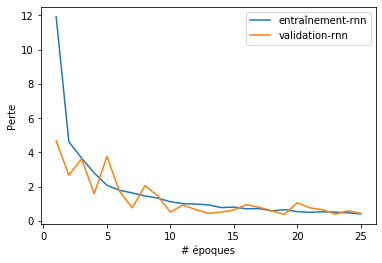

In [ ]:
# Enregistrer l'historique
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='entraînement-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='validation-rnn')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

## Entraînement LSTM

### Exercice: Définir la fonction de coût et l'optimiseur

Rappelons qu'une fonction de coût $J(\theta) = L(x, y, \theta)$ prend en entrée le tuple (prédiction, cible) et calcule une valeur qui estime la distance entre la prédiction et la cible. L'optimiseur que nous utilisons dans cet exemple est celui de la descente de gradient stochastique (*stochastic gradient descent* (SGD)). Il minimise la fonction de coût $J(\theta)$ paramétrisée par les poids du modèle $\theta$ en mettant à jour les poids itérativement suivant la règle de mise à jour suivante: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, où  $\alpha$ est le taux d'apprentissage (*learning rate*).

Pour un problème de régression comme nous avons dans cet exemple, un choix commun est d'utiliser les fonctions suivantes :
<ul>
<li>**Fonction de coût :** <a href="https://pytorch.org/docs/stable/nn.html">`torch.nn.MSELoss()`</a>. L'erreur quadratique moyenne permet de calculer la moyenne de l'écart au carré entre la valeur prédite et la valeur désirée. Cette fonction est définie comme:

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.
    
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> qui est une implémentation de SGD.</li>
</ul>

Nous utilisons une valeur de taux d'apprentissage de 0.001.*

In [ ]:
learning_rate = 0.001

# Définir le critère
criterion = nn.MSELoss()

# Définir l'optimiseur
optimizer_lstm = optim.SGD(model_lstm.parameters(), lr=learning_rate)

### Exercice: Entraînement du model

Nous utilisons notre objet `train_loader` pour itérer à travers notre ensemble d'entraînement *n_epoch* fois pour faire l'entraînement du modèle. La valeur accumulée de la fonction de coût évaluée sur l'ensemble de validation est sauvegardée à la fin de chaque *epoch* d'entraînement.

In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Début de l'entraînement #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Mettre le modèle en mode d'entraînement
    model_lstm.train()
    torch.set_grad_enabled(True)
    
    # Itérer sur les données d'entraînement
    for x, y in train_loader:  

        
        # Mettre les tenseurs sur le matériel (GPU si possible)
        x = x.to(device)
        y = y.to(device)

        # Réinitisaliser les gradients à zéro
        optimizer_lstm.zero_grad()
        
        # Exécuter la propagation avant
        outputs = model_lstm(x)
        
        # Calculer la perte avec le critère
        loss = criterion(outputs, y)
        
        # Exécuter la propagation arrière
        loss.backward()
        
        # Exécuter le pas d'optimisation
        optimizer_lstm.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Mettre le modèle en mode d'évaluation
    model_lstm.eval()
    with torch.no_grad():
    
        # Itérer sur les données de validation
        for x, y in valid_loader:  
        
            # Mettre les tenseurs sur le matériel (GPU si possible)
            x = x.to(device)
            y = y.to(device)
        
            # Exécuter la propagation avant
            outputs = model_lstm(x)
            
            # Calculer la perte avec le critère
            loss = criterion(outputs, y)
        
            # Statistiques
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Époque {:2d} | Perte d'entraînement = {:.5f} | Perte de validation = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Début de l'entraînement #
Époque  1 | Perte d'entraînement = 17.98787 | Perte de validation = 18.18331 
Époque  2 | Perte d'entraînement = 17.94840 | Perte de validation = 18.14885 
Époque  3 | Perte d'entraînement = 17.88981 | Perte de validation = 18.10186 
Époque  4 | Perte d'entraînement = 17.84763 | Perte de validation = 18.02363 
Époque  5 | Perte d'entraînement = 17.72345 | Perte de validation = 17.86540 
Époque  6 | Perte d'entraînement = 17.48216 | Perte de validation = 17.45209 
Époque  7 | Perte d'entraînement = 16.46600 | Perte de validation = 14.88540 
Époque  8 | Perte d'entraînement = 9.01503 | Perte de validation = 5.37170 
Époque  9 | Perte d'entraînement = 3.88117 | Perte de validation = 2.92120 
Époque 10 | Perte d'entraînement = 2.04665 | Perte de validation = 1.69285 
Époque 11 | Perte d'entraînement = 1.28445 | Perte de validation = 1.28987 
Époque 12 | Perte d'entraînement = 0.91663 | Perte de validation = 0.86155 
Époque 13 | Perte d'entraînement = 0.71002 | P

### Visualisation des courbes d'entraînement

Visualisez les courbes d'entraînement avec un graphique mettant en valeur la fonction de coût vs. le nombre d'époques pour les ensembles d'entraînement et de validation sur un même graphe.

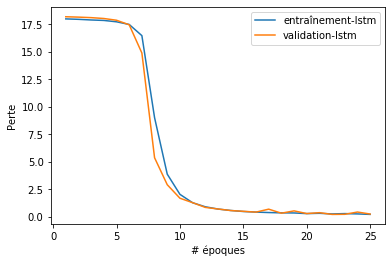

In [ ]:
# Enregistrer l'historique
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
xaxis = range(1, num_epochs + 1)
plt.plot(xaxis, lstm_train_loss_history, label='entraînement-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='validation-lstm')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

## Analyse des résultats

Analysons l'erreur générée par notre modèle sur notre ensemble d'évaluation.  Nous allons comparer l'erreur quadratique moyenne sur l'ensemble d'évaluation pour les modèles RNN et LSTM.

### Exercice: Comparaisons des courbes d'entraînenement

Nous allons comparer sur un même graphique l'erreur en fonction du nombre d'*epochs* lors de notre entraînement sur nos ensembles d'entraînement et de validation.

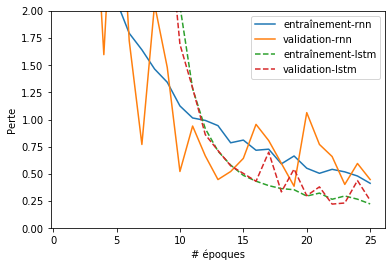

In [ ]:
# Tracer les courbes d'entraînement et de validation
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='entraînement-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='validation-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='entraînement-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='validation-lstm', linestyle='--')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()
plt.ylim([0,2])
plt.show()

Remarquez qu'il y a une différence entre les résultats des RNN et des LSTM.

**Questions**

1.   Quel réseau fonctionne mieux sur notre ensemble de validation? Pourquoi?
2.   Supposons que vous vouliez augmenter l'écart entre les performances du RNN et du LSTM. Comment modifieriez-vous les données ?

... # à compléter.


### Exercice: Calcul de l'erreur sur l'ensemble d'évaluation

Calculez l'erreur quadratique moyenne sur l'ensemble d'évaluation pour les RNN et les LSTM et imprimez les deux valeurs.

In [ ]:
# Mettre les données séquentielles sur le matériel (GPU si possible)
xtest = xtest.to(device)

# Mettre les étiquettes sur le matériel (GPU si possible)
ytest = ytest.to(device)

# Calculer les valeurs prédites par le RNN pour l`ensemble d'évaluation
ypred_rnn = model_rnn(xtest)

# Calculer les valeurs prédites par le LSTM et LSTM pour l`ensemble d'évaluation
ypred_lstm = model_lstm(xtest)

# Calculer la perte du modèle à base de RNN avec le critère
loss_test_rnn = criterion(ypred_rnn, ytest)

# Calculer la perte du modèle à base de LSTM avec le critère
loss_test_lstm = criterion(ypred_lstm, ytest)


print("L'erreur quadratique moyenne d'évaluation du RNN est %2.3f" % float(loss_test_rnn))
print("L'erreur quadratique moyenne d'évaluation du LSTM est %2.3f" % float(loss_test_lstm))

L'erreur quadratique moyenne d'évaluation du RNN est 0.451
L'erreur quadratique moyenne d'évaluation du LSTM est 0.254


### Exercice: Vérification visuelle des résultats

Pour mieux comprendre nos modèles, nous examinerons leurs résultats (c'est-à-dire leurs prédictions avant de calculer le coût). Nous définissons une fonction `print_sequence()` qui aidera à visualiser les prédictions faites par nos modèles. 

Cette fonction prend en entrée les tenseurs X et Y pour échantillonner et imprimer un exemple de séquence ainsi que la différence absolue entre une valeur de Y et la valeur réelle de la somme de X.

Rappelons que nous avons standardisé nos exemples. Pour ces visualisations, nous souhaitons utiliser la pré-normalisation des données originales. Pour ce faire, il faut réutiliser `mean` + `std` tel que 

$xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$


In [ ]:
def print_sequence(X, Y, idx=0):
    """Imprimer et vérifier les séquences d'opérations.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: indice de la séquence à vérifier.
    """
    x = X[idx].numpy()
    y = Y[idx].numpy()
    for i, xi in enumerate(x):
        if i==0:
            string = str(xi[0]) 
        else:
            string += " + " + str(xi[0])
    string1 = string + " = " + str(y[0])
    string2 = string + " = " + str(np.sum(x))
    print("Prédiction: ", string1)
    print("Valeur réelle: ", string2)
    ecart = abs(np.sum(x)-y[0])
    print("Écart absolu entre X[{a}] et Y[{a}]: {b}".format(a=idx, b=ecart))

Complétez le morceau de code suivant en déstandardisant les valeurs `xtest` et `ypred_rnn`.

In [ ]:
xtest = xtest.cpu()
ypred_rnn = ypred_rnn.cpu()

# déstandardiser les données
xtest_unstd = xtest*std + mean
ypred_unstd = ypred_rnn*std + seq_len*mean

idx = np.random.randint(len(ytest))


print("")
print("Exemple RNN:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)



xtest = xtest.cpu()
ypred_lstm = ypred_lstm.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_lstm*std + seq_len*mean

print("")
print("Exemple LSTM:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)


Exemple RNN:

Prédiction:  63.0 + 10.0 + -92.0 + 45.0 + 98.0 + 99.0 + -45.0 + -53.0 + 89.0 + -33.0 + 57.0 + -36.0 + 59.999996 + 22.0 + -22.0 + -40.0 + 52.0 + 0.0 = 341.83246
Valeur réelle:  63.0 + 10.0 + -92.0 + 45.0 + 98.0 + 99.0 + -45.0 + -53.0 + 89.0 + -33.0 + 57.0 + -36.0 + 59.999996 + 22.0 + -22.0 + -40.0 + 52.0 + 0.0 = 274.0
Écart absolu entre X[116] et Y[116]: 67.83245849609375

Exemple LSTM:

Prédiction:  63.0 + 10.0 + -92.0 + 45.0 + 98.0 + 99.0 + -45.0 + -53.0 + 89.0 + -33.0 + 57.0 + -36.0 + 59.999996 + 22.0 + -22.0 + -40.0 + 52.0 + 0.0 = 255.1558
Valeur réelle:  63.0 + 10.0 + -92.0 + 45.0 + 98.0 + 99.0 + -45.0 + -53.0 + 89.0 + -33.0 + 57.0 + -36.0 + 59.999996 + 22.0 + -22.0 + -40.0 + 52.0 + 0.0 = 274.0
Écart absolu entre X[116] et Y[116]: 18.844192504882812


** Questions bonus**

* Répétez l'exercice pour différentes opérations mathématiques (+, -, x, /, ...)
* Faites un graphique comparant la performance des RNN et LSTM en fonction de `seq_len`

---
# Tâche 2: Modèle de langue neuronal


## Objectif
L'objectif de la deuxième partie du tutoriel est d'apprendre à générer des textes à l'aide de réseaux de neurones récurrents. En particulier, nous allons entraîner un réseau de neurones récurrents en utilisant une petite quantité de données textuelles écrites par [Shakespeare](https://en.wikipedia.org/wiki/William_Shakespeare). Une fois ce modèle entraîné, nous l'utiliserons pour générer un nouveau texte dans le style de Shakespeare.

**Notez que les gens utilisent souvent le terme RNN même lorsqu'ils entraînent un LSTM. RNN est devenu le terme générique, quel que soit le type (outre les LSTM, il existe d'autres variantes couramment utilisées, telles que [les unités récurrentes à portes (URP/GRUs)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)).

Le modèle que nous utiliserons est un peu plus complexe que celui de la tâche 1. Contrairement à la section précédente, tout le code est fourni (c'est-à-dire qu'il n'y a pas d'exercices à compléter). Nous vous suggérons de parcourir l'ensemble du code pour vous assurer que vous comprenez à la fois sa logique en ce qui concerne le traitement de texte mais aussi comment concevoir et entraîner un RNN pour la génération de texte. Le code pourrait être relativement facilement adapté à d'autres tâches qui pourraient vous intéresser. 

En outre, ce cahier contient également certaines des étapes de prétraitement des données, en particulier celles qui consistent à prendre notre ensemble de données et à l'organiser de manière à ce qu'il puisse être utilisé pour entraîner un modèle de langage neuronal basé sur les LSTM.  

Bonne génération !

## Encore un peu de contexte théorique

Une séquence de mots $\mathbf{s}$ peut être représentée comme une séquence de symboles discrets $N$ (ou jetons lexicaux) telle que $\mathbf{s} = (w_{1}, \dots, w_{N})$, où $w_{t}$ est un mot ou un signe de ponctuation. Chaque symbole peut être représenté par un entier correspondant à son indice dans le vocabulaire $V$. $V$ contient tous les symboles d'une tâche particulière (le vocabulaire est généralement construit à partir de l'ensemble de données que nous utilisons pour une tâche). L'objectif d'un modèle de langage est d'estimer la probabilité (conjointe) d'une séquence $p(\mathbf{s}) = p(w_{1}, \dots, w_{N})$, qui peut être décomposée comme un produit de probabilités conditionnelles telles que :

\begin{equation}
  p(\mathbf{s}) = \prod^{N}_{t=1} p(w_{t} | w_{1}, \dots, w_{t-1}).
\end{equation}
(ceci est également connu comme la règle de la chaîne dans la théorie des probabilités)

C'est important pour la modélisation. En particulier, au lieu de modéliser directement la distribution conjointe, nous pouvons "simplement" modéliser chaque conditionnel. C'est-à-dire que nous pouvons modéliser la probabilité du mot suivant compte tenu de tous les mots précédents ($p(w_{t} | w_{<t})$). C'est précisément ce que font les modèles linguistiques, qui sont largement utilisés dans de nombreuses applications (notamment dans la traduction automatique, la reconnaissance vocale et la recherche d'informations). Notez que cela peut être compris comme un problème de classification multi-classes où les classes correspondent aux différents mots.

Cependant, la modélisation de chaque condition n'est pas facile. Nous effectuons plutôt une approximation qui rend le problème plus facile. L'intuition derrière l'approximation est qu'au lieu de conditionner l'histoire entière, nous conditionnons sur une histoire plus petite ($w_{t-1}, w_{t-2}, \ldots, w_{t-n}$) pour prédire le mot suivant ($w_{t}$). C'est ce qu'on appelle une hypothèse de Markov d'ordre $n$. Mathématiquement, c'est le cas :
\begin{equation}
  p(w_{t} | w_{1}, \dots, w_{t-1}) \approx p(w_{t} | w_{t-n}, \dots, w_{t-1}).
\end{equation}

Dans le paragraphe suivant, nous expliquons comment modéliser les conditions ci-dessus en utilisant un réseau de neurones récurrent. 

### Modélisation à l'aide des RNN

L'architecture du modèle de langage neuronal que nous utilisons est un réseau LSTM qui apprendra à chaque pas de temps une distribution conditionnelle du mot suivant en utilisant un certain nombre de mots précédents.
Pour entraîner ses paramètres, nous devons d'abord fixer le nombre maximum $n$ de mots précédents à prendre en compte (`seq_len` dans le code)-- c'est la taille effective de votre historique -- pour l'entraînement $p(w_{t} | w_{t-n}, \dots, w_{t-1})$. L'entrée dans le LSTM à chaque étape de temps est : 
- le mot $t^{th}$ $w_t$ encodé à l'aide de son *mot incorporé* (voir ci-dessous) ; 
- l'état récurrent ($\mathbf{h}_{t-1}$) ; et 
- l'état de la mémoire au pas de temps précédent ($\mathbf{c}_{t-1}$).

La sortie du LSTM à chaque étape est le mot suivant $w_{t+1}$. C'est-à-dire que nous entraînons le LSTM à prédire le mot suivant à chaque étape (en détail, le LSTM prédira en fait la probabilité de ce mot suivant). Cela implique également qu'une fois ce modèle entraîné, nous pourrons l'utiliser pour générer du texte (nous choisirons simplement le mot ayant la plus grande probabilité et l'introduirons comme entrée à l'étape suivante). Ce type de modèle est communément connu sous le nom de *modèle de réseau de neurones basé sur LSTM*. Son architecture est présentée ci-dessous :

![alt-text](https://github.com/nextai-mtl/tech-2019/blob/master/images/autoregressive_english.png?raw=true)


Pour calculer la probabilité sur tous les mots suivants, nous utilisons simplement une fonction d'activation *softmax*. La fonction softmax renvoie un vecteur normalisé de dimension $|V|$, où chaque entrée correspond à un seul mot du vocabulaire. Chaque entrée peut être comprise comme la "probabilité" que le mot suivant soit le mot à cet indice.



### Plongement de mots (mots-vecteurs)

La principale question qui reste est de savoir comment encoder exactement les mots à chaque pas de temps. 
Comme les données d'entrée d'un réseau de neurones doivent pouvoir être encodées dans une matrice, chaque symbole (mot) $w_t$ du vocabulaire peut être représenté par un vecteur un-parmi-n *(one-hot)* $\mathbf{x}_i$ qui est un vecteur de zéros avec un seul 1 à la position de l'index de ce mot dans le vocabulaire. Ainsi, ces vecteurs *one-hot* appartiennent à $ \mathbb R^{|V|}$ où $|V|$ est la taille du vocabulaire, c'est-à-dire le nombre de mots dans le vocabulaire. Ces vecteurs one-hot sont multipliés par une matrice de pondération $ \mathbf{E} \in \mathbb R^{|V| \times d_{e}}$. Cette matrice est apprise et est connue sous le nom de *matrice d'incorporation*, $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$, elle encode effectivement les mots dans une représentation continue : $\mathbf{w}_{t} \in \mathbb R^{d_{e}}$.

En utilisant des mots-vecteurs, une séquence de mots peut donc être représentée par une séquence de vecteurs de taille $N$ $\mathbf{s} = (\mathbf{w}_{1}, \dots, \mathbf{w}_{N})$. Chaque ligne $i$ de cette matrice $\mathbf{E}$ est une représentation en dimensions $d_{e}$ du $i$'ème mot du vocabulaire $V$. Comme nous l'avons dit plus haut, ces représentations sont souvent appelées *mots-vecteurs* ou *plongements de mots*. Lorsqu'elles sont apprises à partir d'un ensemble de données suffisamment important, elles peuvent représenter une similarité sémantique. [Pour plus d'informations sur le plongement de mots](http://ruder.io/word-embeddings-1/index.html).

## Fonctions utilitaires de traitement de texte et structuration des données

Pour entraîner notre modèle de langage neuronal, nous utiliserons un ensemble de données (corpus) des travaux de Shakespeare (nous avons utilisé un sous-ensemble de ce lien [https://norvig.com/ngrams/] qui a été nettoyé, tokenisé et standardisé) disponible dans le fichier `shakespeare_top20K.txt`.

Pour obtenir des résultats raisonnables en pratique, nous devrions entraîner un modèle linguistique en utilisant une très grande quantité de texte. Dans ce tutoriel, nous utiliserons un corpus relativement petit de 20000 phrases, 159884 jetons, et un vocabulaire de 12354 jetons. Un token est une unité lexicale séparée par un espace de chaque côté du texte. Dans notre cas, un jeton est un mot, un nombre ou un signe de ponctuation. Le vocabulaire est l'ensemble de tous les jetons d'un corpus. (Bien entendu, notre code se généralise à des ensembles de données plus importants).

In [ ]:
# Cloner git repos pour accéder aux données
!git clone https://github.com/nextai-mtl/tech-2019.git

Cloning into 'tech-2019'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), 999.75 KiB | 1012.00 KiB/s, done.


In [ ]:
START_VOCAB = ["_UNK"]
UNK_ID = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

La fonction `create_vocabulary` prend comme entrée :
- **corpus_path** : chemin vers les données d'un corpus
- **vocab_path** : le chemin où un vocabulaire du corpus fourni sera créé
- **max_vocab_size** : le nombre maximum de mots du vocabulaire

Il crée un vocabulaire composé au maximum de `max_vocab_size` des jetons fréquents dans les données du corpus. Ce vocabulaire est enregistré sous le fichier `vocab_path`.

In [ ]:
def create_vocabulary(corpus_path, vocab_path, max_vocab_size=1e5):
    """Créer et sauvegarder le vocabulaire d'un corpus."""
    vocab = {}
    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                if token in vocab:
                    vocab[token] += 1
                else:
                    vocab[token] = 1
    vocab_list = START_VOCAB + sorted(vocab, key=vocab.get, reverse=True)
    if len(vocab_list) > max_vocab_size:
        vocab_list = vocab_list[:max_vocab_size]
    with open(vocab_path, "w", encoding="utf-8") as f:
        for token in vocab_list:
              f.write(token + "\n")

La fonction " initialize_vocabulary " prend comme entrée :
- **vocab_path** : le chemin d'accès au fichier contenant le vocabulaire

Il renvoie un tuple de deux éléments correspondant respectivement à :
- **vocab** : un dictionnaire `Token:Index` associant un index à chaque token du vocabulaire
- **rev_vocab** : une liste de jetons (uniques) dans le vocabulaire qui associe chaque index à un jeton tel que $vocab [rev\_vocab[i]] = i$.

In [ ]:
def initialize_vocabulary(vocab_path):
    """Initialiser le vocabulaire."""
    if os.path.exists(vocab_path):
        with open(vocab_path, "r", encoding="utf-8") as f:
            rev_vocab = [line.strip() for line in f.readlines()]
        vocab = dict([(w, i) for (i, w) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Fichier de vocabulaire {} pas trouvé.".format(vocab_path))

La fonction `read_corpus` prend comme entrée :
- **corpus_path** : chemin d'accès aux données d'un corpus

Il renvoie les données du corpus sous la forme d'une liste de jetons.

In [ ]:
def read_corpus(corpus_path):
    """Lire et convertir un corpus en une liste de tokens."""
    with open(corpus_path, "r", encoding="utf-8") as f:
        corpus = f.read().split()
    return corpus

La fonction `corpus_to_token_ids` prend comme entrée :
- **corpus** : le corpus comme une liste de jetons
- **vocab** : le vocabulaire sous forme de distionnaire de la forme "taken:index".

Il renvoie une liste de jetons-ids correspondant à la liste de jetons telle que définie par le corpus.

In [ ]:
def corpus_to_token_ids(corpus, vocab):
    """Convertir un corpus en jeton-ids."""
    token_ids = [vocab.get(token, UNK_ID) for token in corpus]
    return token_ids

La fonction `batch_data` prend comme entrée :
- **data** : liste des jeton-ids
- **batch_size** : la taille du lot

Il renvoie une version structurée des données en séquences continues de la taille d'un lot. Les données renvoyées ont une forme `N* x batch_size` où `N* = int(len(data) / batch_size)`.

In [ ]:
def batch_data(data, batch_size):
    """Structurer les données en batch_size séquences continues."""
    n_batch = len(data) // batch_size
    data = np.array(data[:n_batch*batch_size])
    data = data.reshape(batch_size, -1).T
    return data

La fonction `detach_hidden` prend comme entrée :
- **hidden** : état caché d'un RNN

Il transforme les données de cet état caché en un nouveau tenseur avec les mêmes valeurs mais où l'historique de calcul est perdu.

In [ ]:
def detach_hidden(hidden):
    """Transformer les données des états cachés d'un LSTM en
       nouveaux Tensor avec require_grad=False."""
    return tuple(h.detach() for h in hidden)

Voici le morceau de code où les données du corpus sont lues, le vocabulaire est créé et les données du corpus sont structurées en séquences continues de "batch_size" à des fins d'entraînement.

In [ ]:
# Créer et initialiser le vocabulaire.
corpus_path = "tech-2019/data/shakespeare_top20K.txt"
vocab_path = "vocab.txt"

create_vocabulary(corpus_path, vocab_path)
vocab, rev_vocab = initialize_vocabulary(vocab_path)

# Lire le corpus d'entraînement.
corpus = read_corpus(corpus_path)
token_ids = corpus_to_token_ids(corpus, vocab)

# Structurer le corpus en batch_size séquences continues pour faire l'entraînement.
batch_size = 10
data = batch_data(token_ids, batch_size)
data = torch.LongTensor(data).to(DEVICE)

print("Nombre de tokens dans le corpus: {}"
      .format(len(corpus)), end="\n\n")
print("Taille du vocabulaire: {}"
      .format(len(vocab)), end="\n\n")
print("Liste des 20 jetons les plus fréquents dans le corpus: \n{}"
      .format(rev_vocab[1:21]), end="\n\n")
print("Première phrase du corpus en format texte:\n{}"
      .format(" ".join(corpus[:31])), end="\n\n")
print("Première phrase du corpus transformée en jeton-ids:\n{}"
      .format(token_ids[:31]), end="\n\n")
print("Test de conversion jeton-ids vers texte en utilisant rev_vocab:\n{}"
      .format(" ".join([rev_vocab[i] for i in token_ids[:31]])), end="\n\n")
print("Structure des données d'entraînement (observez que la première phrase "
      "est dans la première colonne):\n{}".format(data[:20]))

Nombre de tokens dans le corpus: 159884

Taille du vocabulaire: 12354

Liste des 20 tokens les plus fréquents dans le corpus: 
[',', '.', 'the', 'I', ';', 'and', 'to', 'of', 'you', 'a', ':', 'in', '?', 'my', 'is', 'that', '!', 'not', 'it', 'me']

Première phrase du corpus en format texte:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

Première phrase du corpus transformée en token-ids:
[70, 5876, 5877, 194, 1, 143, 1948, 1, 58, 1425, 319, 4108, 46, 1949, 11, 607, 778, 608, 275, 12, 1950, 415, 5, 35, 62, 17, 1042, 119, 1115, 114, 173]

Test de conversion token-ids vers texte en utilisant rev_vocab:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

Structure des données d'entraînement (observez que la première phrase est dans la première colonne):
tensor([[   70,  3426, 

Dans le bloc suivant, nous divisons les données en ensembles de données d'entraînement et de validation et nous créons les collecteurs de données correspondants. Nous utilisons 10 % des données pour l'ensemble de validation.

In [ ]:
# créer ensembles entraînement/validation et créer DataLoaders.
X = data[:-1]
Y = data[1:]

n_valid = round(data.size(0) * 0.1)
train_set = TensorDataset(X[:(data.size(0)-n_valid)], Y[:(data.size(0)-n_valid)])
valid_set = TensorDataset(X[-n_valid:], Y[-n_valid:])

seq_len = 40
train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=seq_len, shuffle=False)

print("Ensemble d'entraînement: {} séquences de longueur {} et {} minibatches"
      .format(len(train_set), seq_len, len(train_loader)))
print("Ensemble de validation : {} séquences de longueur {} et {} minibatches"
      .format(len(valid_set), seq_len, len(valid_loader)))

Ensemble d'entraînement: 14389 séquences de longueur 40 et 360 minibatches
Ensemble de validation : 1599 séquences de longueur 40 et 40 minibatches


## Implémentation du modèle

Ci-dessous se trouve le code du *LSTM-based neural language model* décrit dans la section **Encore un peu de contexte théorique (car vous aimez vraiment ça)**.

À chaque pas de temps les variables d'entrées dans le LSTM sont:

1.    une minibatch de séquences de jeton-ids (c.à.d. des séquences d'indices où chaque indice représente la position d'un token dans un vocabulaire);
2.    des tuples $(\mathbf{h}_{0}, \mathbf{c}_{0})$ des états récurrents et des états mémoires équivalent aux $(\mathbf{h}_{T}, \mathbf{c}_{T})$ de la minibatch précédente (sauf pour la première minibatch où nous initialisons les valeurs de ces variables à 0.0 avec la fonction `init_hidden()`).

Chaque séquence de jeton-ids est transformée en séquence de *mots-vecteurs* en indexant les représentations *mots-vecteurs* créés par la classe [torch.nn.Embedding()](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) qui est une matrice de paramètres de dimension $|V| \times d_{e}$, où $|V|$ est la taille du vocabulaire (`vocab_size`) et $d_{e}$ est la dimension d'un *mot-vecteur* (`embedding_size`).

Nous appliquons de l'extinction de neurones sur les *mots-vecteurs* en entrée et sur la couche de sortie pour régulariser le modèle.

In [ ]:
class LanguageModel(nn.Module):
    """Modèle de langue neuronal à base de LSTM."""
    
    def __init__(self, vocab_size, input_size, hidden_size, n_layers=1, dropout=0.5):
        """
        Args:
          vocab_size: taille du vocabulaire.
          input_size: taille des mots-vecteurs.
          hidden_size: taille des états cachés du LSTM.
          n_layers: nombre de couches du LSTM (default: 1).
          dropout: si non-zéro, introduit une couche d'extinction de neurones à l'entrée et à la sortie
                   du LSTM, avec une probabilité égale d'extinction de neurones (default: 0.5).
        """        
        super(LanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embeddings = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            n_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input, hidden):
        embeddings = self.dropout(self.embeddings(input))
        output, hidden = self.lstm(embeddings, hidden)
        output = self.dropout(output)
        result = self.linear(output.view(output.size(0)*output.size(1), output.size(2)))
        return result.view(output.size(0), output.size(1), result.size(1)), hidden

    def init_weights(self):
        init.uniform_(self.embeddings.weight, -0.1, 0.1)
        init.xavier_uniform_(self.linear.weight, init.calculate_gain("linear"))
        init.constant_(self.linear.bias, 0)
        
    def init_hidden(self, batch_size):
        """Initialiser les valeurs de l'état caché et la cellule du LSTM à zéro.
        Args:
          batch_size: taille de la mini-batch à un pas de temps.
          
        Returns:
          hidden: état caché h_t et la cellule c_t à t=0 initialisés à 0, 
                  ((n_layers, batch_size, hidden_size),
                   (n_layers, batch_size, hidden_size)).
        """
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE))
        return hidden

## Entraînement du modèle
L'entraînement du modèle se fait presque de la même manière que dans la tâche 1. Les éléments clés différents sont les suivants:
* Nous appliquons de l'extinction de neurones sur les *mots-vecteurs* en entrée et la couche de sortie du LSTM. Étant donné que la taille de notre ensemble d'entraînement est très petite, il est alors facile pour notre modèle de faire du surapprentissage. Pour les modéles génératifs autorégressifs à base de RNN, il est fortement recommandé d'utiliser une probabilité d'extinction de neurones élevée pour éviter l'effet de surapprentissage des données.
* Nous démarrons l'entraînement avec une valeur de `learning_rate` élevée et nous la diminuons par un facteur de 10 en fonction de la perte sur l'ensemble de validation évaluée à la fin de chaque *epoch* d'entraînement en utilisant la classe [torch.optim.lr_scheduler.ReduceLROnPlateau()](https://pytorch.org/docs/stable/optim.html?highlight=plateau#torch.optim.lr_scheduler.ReduceLROnPlateau).
* Pour éviter le *problème de l'explosion du gradient*, nous appliquons la technique de *l'écrêtage de gradient* en normalisant la norme du gradient avec la fonction [torch.nn.utils.clip_grad_norm_()](https://pytorch.org/docs/stable/nn.html?highlight=clip#torch.nn.utils.clip_grad_norm_).
* Nous initialisons avec des valeurs de 0.0 le tuple $(\mathbf{h}_{0}, \mathbf{c}_{0})$ de l'état récurrent et l'état mémoire `hidden` avec la fonction `init_hidden()` uniquement une fois au début de chaque *epoch* d'entraînement et nous propageons les nouvelles valeurs de `hidden` à travers chaque minibatch d'entraînement. En d'autres mots, les données ont été structurées à l'aide de la fonction `batch_data()` de manière à ce que nous pouvons initialiser `hidden` $(\mathbf{h}_{0}, \mathbf{c}_{0})$ de chaque séquence d'une nouvelle minibatch par $(\mathbf{h}_{T}, \mathbf{c}_{T})$ de la minibatch précédente. Un désavantage de cette méthode est que nous ne pouvons pas mélanger l'ordre des séquences à chaque *epoch* d'entraînement (c.à.d. `train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)`).
* Notre fonction de coût est l'entropie croisée [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss).
* Nous présentons la mesure de *[Perplexité](https://en.wikipedia.org/wiki/Perplexity)* qui est une mesure d'évaluation de la qualité d'un modèle de langue.

In [ ]:
# Construire le modèle.
vocab_size = len(vocab)
embedding_size = 300
hidden_size = 400
n_layers = 1
dropout = 0.65
model = LanguageModel(vocab_size, embedding_size, hidden_size, n_layers, dropout).to(DEVICE)
print("Nombre de paramètres dans le modèle:", sum(param.nelement() for param in model.parameters()))

# Fonction de coût et optimiseur.
learning_rate = 10
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

# Entraînement du modèle.
n_epochs = 20
max_grad_norm = 1

print("Entraînement du modèle pour {} epochs de {} minibatches".format(n_epochs, len(train_loader)))
for epoch in range(n_epochs):
    model.train()
    hidden = model.init_hidden(batch_size)
    train_loss = 0
    valid_loss = 0
    for x, y in train_loader:
        # Détacher les états cachés précédents du graphe computationnel.
        hidden = detach_hidden(hidden)
        
        # Réinitialiser le gradient.
        optimizer.zero_grad()
                
        # propagation avant.
        y_pred, hidden = model(x, hidden)
        
        # Calculer la perte.
        loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
        
        # Calculer le gradient.
        loss.backward()
        
        # Normaliser le gradient pour éviter explosion.
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # Mettre à jour les paramètres du modèle.
        optimizer.step()        
        
        # Accumuler la perte total.
        train_loss += len(x) * loss.item()
    
    # Évaluer le modèle sur l'ensemble de validation.
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(batch_size)
        for x, y in valid_loader:
            y_pred, hidden = model(x, hidden)
            loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
            valid_loss += len(x) * loss.item()
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    scheduler.step(valid_loss)

    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} | Perplexity = {:.2f}"
          .format(epoch+1, train_loss, valid_loss, np.exp(valid_loss)))
print("Félicitations! Vous avez terminé d'entraîner votre beau modèle de langue neuronal!")

## Génération de texte

Maintenant que nous avons entraîné un modèle linguistique, nous pouvons l'utiliser pour générer un texte comme Shakespeare ! 
Pour ce faire, nous sélectionnerons au hasard le premier mot (c'est-à-dire un jeton dans un vocabulaire) et l'utiliserons comme jeton d'entrée à la première étape. Nous utiliserons ensuite le mot de sortie au premier pas de temps comme mot d'entrée au deuxième pas de temps et ainsi de suite. Au total, nous allons générer des `n_words`.La variable `smoothing` permet d'obtenir une modification de la diversité du texte généré. Une valeur plus élevée permet de générer un texte plus diversifié mais souvent de moindre qualité.

In [ ]:
# Génération de séquences de mots.
model.eval()
x = torch.randint(0, vocab_size, (1, 1), dtype=torch.long, device=DEVICE)
words = [rev_vocab[x]]
n_words = 300
smoothing = 0.7
with torch.no_grad(): 
    hidden = model.init_hidden(1)
    for i in range(n_words-1):
        output, hidden = model(x, hidden)
        weights = output.squeeze().div(smoothing).exp()
        word_idx = torch.multinomial(weights, 1)
        x.fill_(word_idx.squeeze())
        word = rev_vocab[word_idx]
        words.append(word)
        if (i+1) % 15 == 0:
            words.append("\n")
print(" ".join(words))

skilfully , For his 'My a hates of the The king . I are own life 
 . beasts I ladyships a gentility : let are our first . I may her 
 you it . I am I shall your them ; Ay you to the sings 
 ; I will may them . Count shall a safer , and nothing . Be 
 I am you of : I will so . And so I love ; a 
 lord , and to the loving : I am with in mother . I know 
 I had thy fame . I will all I do your equally ; and I 
 one it's : And would be as my sun-rise not . I cave with him 
 . But I say him . You was tongue is a good well . I 
 am for his fortune of the ; and as you then as for such good 
 of the hour ; and you shall a lord . I I am I will 
 both when for a vice . I shall not with him . I will him 
 ; none ; heaven me in her sworn . I am me Where . I 
 am you of my way . Truly death thou doth come time . I know 
 of a fairings . Will not be . You are not to I am would 
 my look find ; I know a search , and you give not . Well 
 of he the Holla ; I have in his Remit . You truly in this 
 love

Qu'en pensez-vous? À première vue, bien que certaines séquences de mots peuvent être cocasses, la clarté du texte généré n'est pas la meilleure. 

En effet, nous observons que la virgule (`,`) apparaît souvent dans le texte et cela est dû au fait que la virgule s'agit du jeton le plus fréquent dans notre corpus.  

Pour améliorer la clarté du texte généré, il serait nécessaire d'entraîner le modèle sur un corpus de plus grande taille. De plus, nous soulignons que le vocabulaire et le style littéraire de notre cher Shakespeare ne sont pas les plus conventionnels! Au final, il ne faut pas oublier que nous avons simplement appris une distribution de probabilité basée sur les statistiques d'un corpus.

---
## Références
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

* https://arxiv.org/abs/1803.08240

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/